In [71]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

In [72]:
df = pd.read_csv('USD_TJS Historical Data (1).csv')

In [73]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,04/16/2025,10.7977,10.7977,10.7977,10.7977,NaN,-0.02%
1,04/15/2025,10.8000,10.8550,10.9300,10.8200,NaN,-0.18%
2,04/14/2025,10.8200,10.9300,10.9300,10.8450,NaN,0.00%
3,04/11/2025,10.8200,10.8800,10.9300,10.8400,NaN,0.00%
4,04/10/2025,10.8200,10.9300,10.9300,10.8400,NaN,0.00%
...,...,...,...,...,...,...,...
1334,01/07/2020,9.6933,9.6980,9.6983,9.6900,NaN,0.00%
1335,01/06/2020,9.6930,9.6965,9.6980,9.6900,NaN,0.06%
1336,01/03/2020,9.6870,9.6913,9.6965,9.6865,NaN,0.01%
1337,01/02/2020,9.6863,9.6930,9.6950,9.6865,NaN,-0.02%


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339 entries, 0 to 1338
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1339 non-null   object 
 1   Price     1339 non-null   float64
 2   Open      1339 non-null   float64
 3   High      1339 non-null   float64
 4   Low       1339 non-null   float64
 5   Vol.      0 non-null      float64
 6   Change %  1339 non-null   object 
dtypes: float64(5), object(2)
memory usage: 73.4+ KB


In [75]:
df = df.drop(['Vol.'], axis=1)

In [76]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

In [77]:
df

,Date,Price,Open,High,Low,Change %
0,2025-04-16,10.7977,10.7977,10.7977,10.7977,-0.02%
1,2025-04-15,10.8000,10.8550,10.9300,10.8200,-0.18%
2,2025-04-14,10.8200,10.9300,10.9300,10.8450,0.00%
3,2025-04-11,10.8200,10.8800,10.9300,10.8400,0.00%
4,2025-04-10,10.8200,10.9300,10.9300,10.8400,0.00%
...,...,...,...,...,...,...
1334,2020-01-07,9.6933,9.6980,9.6983,9.6900,0.00%
1335,2020-01-06,9.6930,9.6965,9.6980,9.6900,0.06%
1336,2020-01-03,9.6870,9.6913,9.6965,9.6865,0.01%
1337,2020-01-02,9.6863,9.6930,9.6950,9.6865,-0.02%


In [78]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(series, alpha=0.05):
    result = adfuller(series.dropna())
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    for key, value in result[4].items():
        print(f"Critical Value ({key}): {value}")
    
    if result[1] < alpha:
        print("\n✅ Ряд стационарен (отвергаем нулевую гипотезу)")
    else:
        print("\n❌ Ряд нестационарен (не отвергаем нулевую гипотезу)")

In [79]:
test_stationarity(df['Price'])

ADF Statistic: -1.7359635998612095
p-value: 0.41268464611313505
Critical Value (1%): -3.435291179714802
Critical Value (5%): -2.8637221386381198
Critical Value (10%): -2.567931778583112

❌ Ряд нестационарен (не отвергаем нулевую гипотезу)


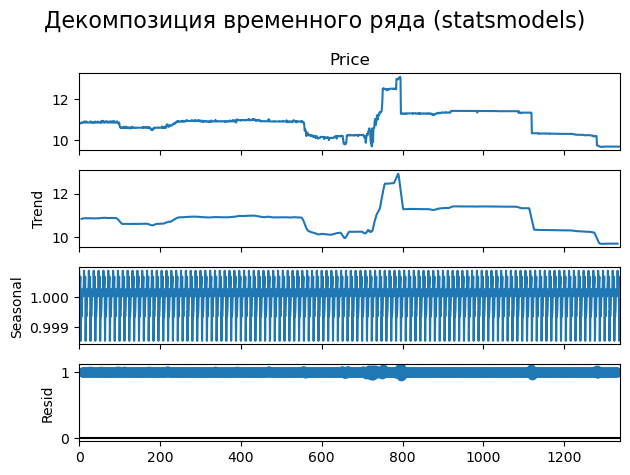

In [80]:
decomp_result = seasonal_decompose(df['Price'], model='multiplicative', period=12)

decomp_result.plot()
plt.suptitle('Декомпозиция временного ряда (statsmodels)', fontsize=16)
plt.tight_layout()
plt.show()

In [81]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y_actual, y_predicted):
    rmse = sqrt(mean_squared_error(y_actual, y_predicted))
    return rmse

In [82]:
w_hours = 120
train = df.iloc[w_hours:]
val   = df.iloc[:w_hours]

# 1 Model

In [83]:
preds = [train.Price.mean()] * w_hours

In [84]:
print('RMSE - ', rmse(val.Price, preds))
print('MAPE - ', mean_absolute_percentage_error(val.Price, preds)*100)

RMSE -  0.09941561460658217
MAPE -  0.6359023976201637


# 2 Model

In [85]:
preds = train.iloc[:w_hours].Price.values

In [86]:
print('RMSE - ', rmse(val.Price, preds))
print('MAPE - ', mean_absolute_percentage_error(val.Price,  preds)*100)

RMSE -  0.25124982885566316
MAPE -  2.2102798073490404


# 3 Model

In [87]:
n = 5
tr_sample = train.iloc[:n*w_hours]
preds_arr = np.array(tr_sample.Price).reshape(n,-1)

preds = preds_arr.mean(axis = 0)

In [88]:
print('RMSE - ', rmse(val.Price, preds))
print('MAPE - ', mean_absolute_percentage_error(val.Price,  preds)*100)

RMSE -  0.1784057659849217
MAPE -  1.481430686494835


# 4 Model

In [89]:
# учитываем уровень, тренд, и сезон
from statsmodels.tsa.api import ExponentialSmoothing

fit1 = ExponentialSmoothing(np.asarray(train.Price), trend='add', seasonal=None,).fit()
forecast = pd.Series(fit1.forecast(len(val)))
forecast.index = val.index

In [90]:
print('RMSE - ', rmse(val.Price, forecast))
print('MAPE - ', mean_absolute_percentage_error(val.Price, forecast)*100)

RMSE -  1.179237366034882
MAPE -  10.864259526788851


# 5 Model

In [91]:
import itertools
import warnings
import tqdm
from tqdm.auto import tqdm
warnings.filterwarnings("ignore")

p = q = range(0,10)
d = range(0,5)
pdq = list(itertools.product(p, d, q))
best_params = (0,0,0)
best_rmse = np.inf

for params in tqdm(pdq):
    model_test = sm.tsa.arima.ARIMA(val.Price, order = params)
    result_test = model_test.fit()
    preds = result_test.predict(dynamic=False)

    rmse_ = mean_absolute_percentage_error(val.Price, preds)
    if rmse_ < best_rmse:
        best_params = params
        best_rmse = rmse_
print(best_params, 'MAPE - ', best_rmse)

  0%|          | 0/500 [00:00<?, ?it/s]

(8, 0, 9) MAPE -  0.0021647854223090625


# 6 Model

In [92]:
from prophet import Prophet

df_prophet = df[['Date', 'Price']].rename(columns={'Date': 'ds', 'Price': 'y'})

train_pr = df_prophet.iloc[w_hours:]
val_pr   = df_prophet.iloc[:w_hours]

model = Prophet(daily_seasonality=False, yearly_seasonality=False, changepoint_prior_scale=0.001, n_changepoints=7)
model.fit(train_pr)

19:39:33 - cmdstanpy - INFO - Chain [1] start processing
19:39:34 - cmdstanpy - INFO - Chain [1] done processing


In [122]:
future = model.make_future_dataframe(periods=120, freq='D', include_history=False)
forecast = model.predict(future)

In [123]:
a = []
for i in range(len(forecast.values)-1, -1, -1):
    a.append(forecast.values[i][1])

In [124]:
print('RMSE - ', rmse(val.Price, a))
print('MAPE - ', mean_absolute_percentage_error(val.Price, a)*100)

RMSE -  0.1120048659457339
MAPE -  0.9786553119412502
